# Exploratory Data Analysis
## Summary
* Most of the variables are the principal components (V1 to V28).
* There are no missing values no infinite values. Overall, except for some minor scaling, there isn't much to clean or impute.
* The target feature - `Class`, is very imbalanced. In ratio 1000:17.
* The only non-PCA features are: `Time`, `Amount` and `Class`.
* `Amount` is heavily skewed to the right. Most of the transactions didn't even exceed 100\$.
* I'll standardize `Time` and `Amount`.
    * I'll use RobustScaler for the `Amount` feature, as it contains many outliers.
        * I was also considering StandardScaler, but the assumption is to have a normally distributed data, which we don't have here.
    * `Time` will go with the MinMaxScaler, as there I didn't see any outliers, but I'm also concerned about the distribution not being close to normal.
    * Although based on the fact, that some of the models I'm going to run are not sensitive to transformations of data (except for SVC and Logistic Regression's regularization term), I'm motivated to test if standarization actually improves/detoriates the results for those model not requiring standarization (XGBoost and Random Forest). But this will happen if I have enough time to perform this additional test.
        * Note: XGBoost implements a second algorithm, which is based on linear boosting. Scaling might influence it. Thus testing might be even more interesting!

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

%matplotlib inline

In [ ]:
raw_data_df = pd.read_csv('data/creditcard.csv')

From the description of the dataset we're dealing with lots of features (specifically from V1 to V28) that were already reduced via PCA, thus, limiting our understanding of what's happening there.

In [5]:
raw_data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [93]:
# Checking if there are any artifacts in the PCA transformed columns.
# Summing the resulting series for brevity.
print(f"NA count: {raw_data_df.isna().sum().sum()}")
print(f"Inf values count: {raw_data_df[raw_data_df == np.inf].sum().sum()}")

NA count: 0
Inf values count: 0.0


There are no columns with NA fields inside nor any infinite values.

We can already see, that what's left of non-PCA transformed colums are the `Amount`, `Time`, and `Class` features. 

* `Amount` looks heavily skewed, need to confirm it via histogram.
    * Additionally, looks like some of the values are 0 here. Not sure if this is something that should be dropped or not. For now, I'm going to leave it assuming this is possible.
* `Class` is our predicted value. It's either 0 (no-fraud) and 1 (fraud).
    * It's already visible that there's quite big imbalance in this series. Will confirm it with a barplot.
* `Time` was defined as "number of seconds elapsed between this transaction and the first transaction in the dataset". Not sure how much information it can provide, but I'm gonna leave it just in case.

I'll check it after looking up the correlation matrix.

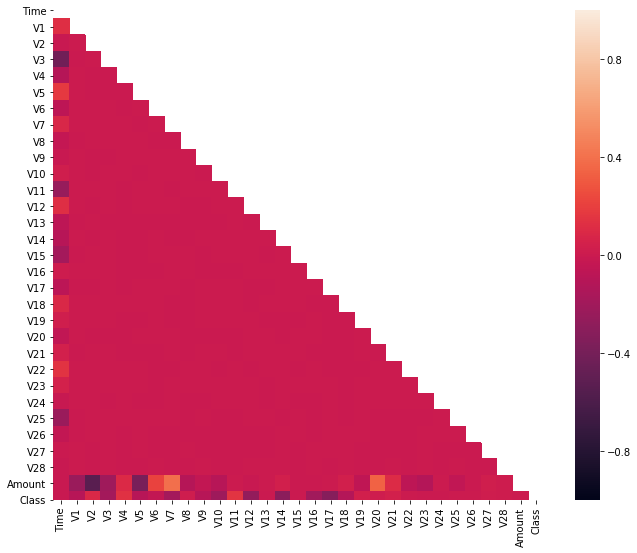

In [35]:
# mask for upper triangle
corr = raw_data_df.corr()
mask = pd.np.zeros_like(corr, dtype=np.bool)
mask[pd.np.triu_indices_from(mask)] = True

# make it bigger
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1.0, vmin=-1.0)
plt.show()

We can see that the strongest correlation occurs between Amount <> V7, Amount <> V20, and Amount <> V2.  
Also, there isn't any strong correlation between the Class and other features, maybe except V17.

In [20]:
corr.loc[["Amount", "Class"], ["V2", "V7", "V17", "V20"]]

,V2,V7,V17,V20
Amount,-0.531409,0.397311,0.007309,0.339403
Class,0.091289,-0.187257,-0.326481,0.020090


There's no correlation above 0.4 except Amount <> V2. Amount <> V7 is close to the 0.4 r.

Overall the dataset looks really solid in this department. And due to previous application of PCA there are no multicollinearity issues.

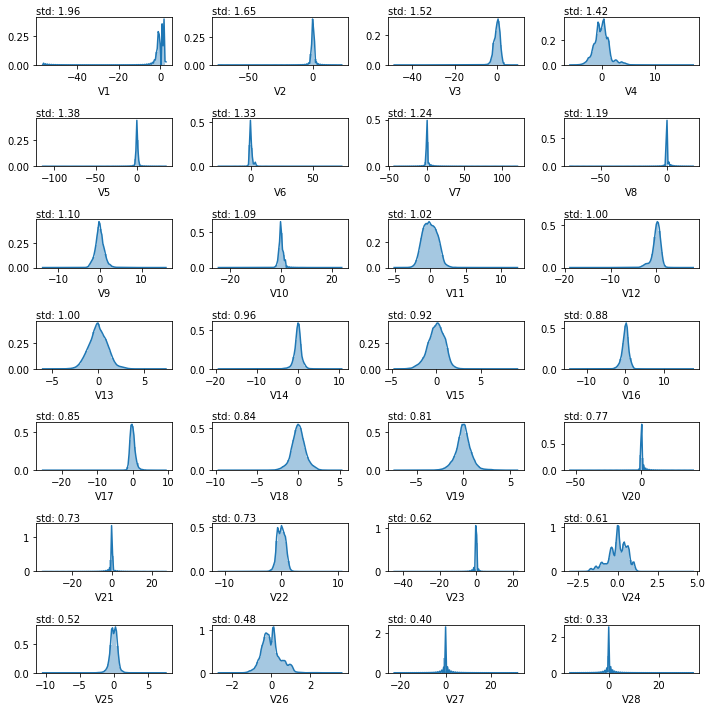

In [180]:
f, ax = plt.subplots(nrows=7, ncols=4, figsize=(10, 10))
ax = ax.flatten()
for i, column in enumerate((f"V{i}" for i in range(1, 28+1))):
    sns.distplot(raw_data_df[column], ax=ax[i])
    left = ax[i].get_xbound()[0]
    top = ax[i].get_ybound()[1] + ax[i].get_ybound()[1] * .05
    ax[i].text(x=left, y=top, s=f"std: {raw_data_df[column].std():.2f}")

plt.tight_layout()

This confirms that it's a typical PCA transformation. Was just curious to check it.

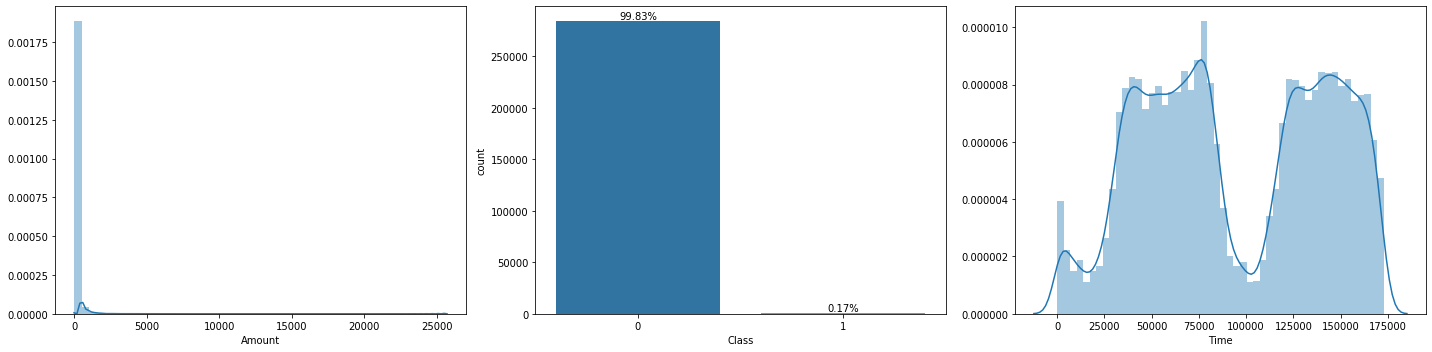

In [186]:
# Check the distributions for those three non-PCA'd features.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.distplot(raw_data_df["Amount"], ax=ax[0])
sns.countplot(raw_data_df["Class"], ax=ax[1])
sns.distplot(raw_data_df["Time"], ax=ax[2])

# Add labels on top of the bars with % of it's count
for rect, percent in zip(ax[1].patches, raw_data_df["Class"].value_counts(normalize=True)):
    ax[1].text(rect.get_x() + rect.get_width()/2, rect.get_height() + 5, f"{percent*100:.2f}%", ha="center", va="bottom")

plt.tight_layout()


* `Amount` is heavily skewed and has quite a big scale (compared to PCA values), with most being less than 100\\$ (this is based on the 75% quartile being still under 100\\$). It will require standarization ~or taking the log of it~.
    * Can't take logarithm due to some observations having 0 and 1 spend. I could just put in a constant, but this will be a messy process as log(1) = 0. Thus, standarization might be a better idea.
    * \+ SVC will be happy to have scaled data (faster convergence) and this will also allow us to go with regularization in Logistic Regression.
* `Class` is clearly imbalanced. Only 0.17% is assigned to the target class we're trying to predict.
    * I'll need to either re-balanced it while doing cross validation via resampling methods, OR I can use cost sensitive learning based methods.
* `Time` it looks like the range was 2 days. We can also see 2 dips that could suggest it being a nighttime. I think, based on this, that this column should be still used, as it could potentially provide additional information.
    * Scaling this will also be necessary due to large magnitude of min-max values compared to other features. Only applicable to SVC and the regularization term in Logistic Regression.
    
Note: I'm not sure how important are the `Amount` and `Time` features, thus I won't manually adjust the standard deviation when standardizing them (only applicable to models which rely on magnitude).

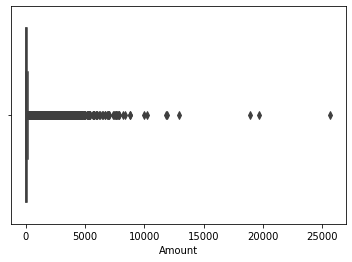

In [181]:
sns.boxplot(raw_data_df["Amount"])

Lot's of outliers are present outside of the IQR.

## Preprocessing impact

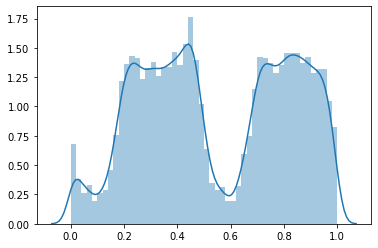

In [194]:
sns.distplot(preprocessing.MinMaxScaler().fit_transform(raw_data_df["Time"].values.reshape(-1, 1)))